### Topic: Predicting Hospital Re-admission for Diabetes Patients

#### Problem Statement
The dataset being chosen is [Diabetes 130-US hospitals for years 1999-2008 Data Set](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008). It represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks for diabetes patients. Over 50 features representing patient and hospital outcomes were recorded. There are two objectives that I have defined for the project:
- Data analysis: find, analyze, and establish correlation between different feature attributes
- Machine learning: build a model to predict hospital readmission

#### Dataset Analysis
**Dataset creation**
This dataset is built using the Health Facts database, a national data warehouse that collects comprehensive clinical records across the hospital throughout the United States. The Health Facts data used was an extract representing 10 years (1999–2008) of clinical care at 130 hospitals and integrated delivery networks throughout the United States. The database consists of 41 tables in a fact-dimension schema and a total of 117 features. The database includes 74,036,643 unique encounters (visits) that correspond to 17,880,231 unique patients and 2,889,571 providers. To create the dataset, select information was extracted from this original database that satisfied the following criteria:

1. It is an inpatient encounter (a hospital admission)
2. It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis
3. The length of stay was at least 1 day and at most 14 days
4. Laboratory tests were performed during the encounter
5. Medications were administered during the encounter

A total of 101,766 instances were identified to fulfill the above five criteria. Feature selection was performed by clinical experts and only attributes that were potentially relevant with diabetic condition were retained. A total of 55 (out of 114) attributes were selected describing the diabetic encounters, including demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information. However, the dataset available on the UCI repository has only 50 features. The full list is shown below:

In [2]:
import pandas as pd

df = pd.read_csv('diabetic_data.csv')
print(f'There are a total of {len(df.columns)} features for every patient admitted. The full list is enumerated below {list(df.columns)}')
print(f'Total number of datapoints are {len(df)}')

There are a total of 50 features for every patient admitted. The full list is enumerated below ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']
Total number of datapoints are 101766


Since the study conducted with this dataset were interested in factors that lead to early readmission, the readmission attribute (outcome) is defined as having two values: "readmitted", if the patient was readmitted within 30 days of discharge or "otherwise", which covers both readmission after 30 days and no readmission at all.

There were several features that could not be treated directly since they had a high percentage of missing values. These features were weight (97% values missing), payer code (40%), and medical specialty (47%). Weight attribute was considered to be too sparse and it was not included in further analysis. Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values. Large percentage of missing values of the weight attribute can be explained by the fact that prior to the HITECH legislation of the American Reinvestment and Recovery Act in 2009 hospitals and clinics were not required to capture it in a structured format.

The preliminary dataset contained multiple inpatient visits for some patients and the observations could not be considered as statistically independent, an assumption of the logistic regression model. Thus, only one encounter per patient is used; in particular, we considered only the first encounter for each patient as the primary admission and determined whether or not they were readmitted within 30 days. Additionally, the authors removed all encounters that resulted in either discharge to a hospice or patient death were removed, to avoid biasing our analysis. After performing the above-described operations, we were left with 69,984 encounters that constituted the final dataset for analysis. The variables chosen to control for patient demographic and illness severity were gender, age, race, admission source, discharge disposition, primary diagnosis , medical specialty of the admitting physician, and time spent in the hospital.

**Summary**: To summarize, the dataset consists of hospital admissions of length between one and 14 days that did not result in a patient death or discharge to a hospice. Each encounter corresponds to a unique patient diagnosed with diabetes, although the primary diagnosis may be different. During each of the analyzed encounters, lab tests were ordered and medication was administered.

**Analysis**


##### #1 Composition of Race and Gender
It is evident from the race composition pie chart that the data is highly biased towards the 'white' people. The second most popular group is African-American while the other ethnicities are scarcely present. However, the data is fairly balanced in terms of gender, with near equal composition from both. With rising awareness of gender neutrality, the gender attribute should soon move away from the current binary system.

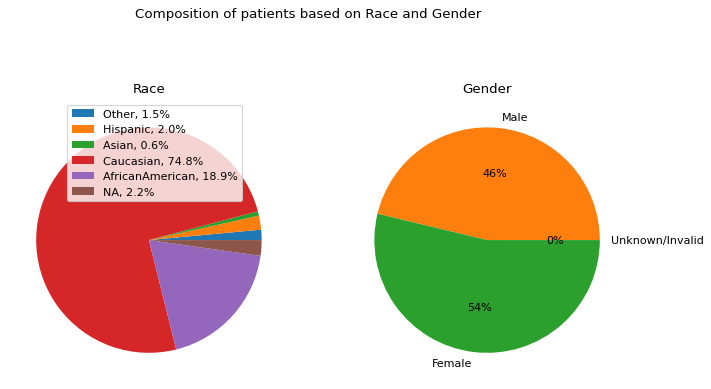

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

# fetch data specific to race of the patients
race_data = list(df.loc[:, 'race'])
race_dict = dict((x,race_data.count(x)) for x in set(race_data))
race_values = list(race_dict.values())
race_labels = list(race_dict.keys())
race_labels[race_labels.index('?')] = 'NA'

# initialize the figure
figure(figsize=(10, 6), dpi=80)

# calculate some values to make sure the labels are not overlapping each other
sizes = np.array(race_values)/np.array(sum(race_values))*100
labels = [f'{l}, {s:0.1f}%' for l, s in zip(race_labels, sizes)]

# plotting data on pie chart
plt.subplot(1, 2, 1)
plt.title('Race')
plt.pie(race_values)
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper right', labels=labels)

# fetch data specific to race of the patients
gender_data = list(df.loc[:, 'gender'])
gender_dict = dict((x,gender_data.count(x)) for x in set(gender_data))
gender_values = list(gender_dict.values())
gender_labels = list(gender_dict.keys())

# plotting data on pie chart
plt.subplot(1, 2, 2)
plt.title('Gender')
plt.pie(gender_values, labels=gender_labels, autopct='%.0f%%')

plt.suptitle('Composition of patients based on Race and Gender')
plt.show()

##### #2 Readmissions versus the HbA1c
A hemoglobin A1C (HbA1C) test is a blood test that shows what your average blood sugar (glucose) level was over the past two to three months. An A1C test can show your average glucose level for the past three months because:
- Glucose sticks to hemoglobin for as long as the red blood cells are alive.
- Red blood cells live about three months.

High A1C levels are a sign of high blood glucose from diabetes. It is an important measure of glucose control, which is widely applied to measure performance of diabetes care. A level >8% is considered borderline diabetis while <7% is considered normal. In an ideal situation, high HbA1c level should have more likelihood of readmission into the hospital.

84748 patients were not tested for HbA1c level.


Text(0.5, 1.0, 'Readmission as a function of HbA1c level')

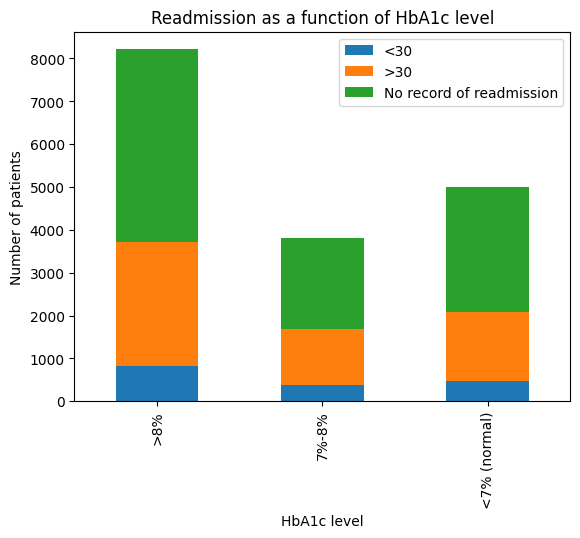

In [5]:
# list of data points for patients that were readmitted 
df_hb1ac_grt_8  = list(df['readmitted'][df.A1Cresult == '>8'])
df_hb1ac_bw_7_8 = list(df['readmitted'][df.A1Cresult == '>7'])
df_hb1ac_less_7 = list(df['readmitted'][df.A1Cresult == 'Norm'])
df_hb1ac_none   = list(df['readmitted'][df.A1Cresult == 'None'])

print(f'{len(df_hb1ac_none)} patients were not tested for HbA1c level.')

df_readmission_hb1ac = pd.DataFrame({
            '<30': [df_hb1ac_grt_8.count('<30'), df_hb1ac_bw_7_8.count('<30'), df_hb1ac_less_7.count('<30')],
            '>30': [df_hb1ac_grt_8.count('>30'), df_hb1ac_bw_7_8.count('>30'), df_hb1ac_less_7.count('>30')],
            'No record of readmission': [df_hb1ac_grt_8.count('NO'), df_hb1ac_bw_7_8.count('NO'), df_hb1ac_less_7.count('NO')]},
            index=['>8%', '7%-8%', '<7% (normal)'])
 
df_readmission_hb1ac.plot(kind='bar', stacked=True)
 
# # labels for x & y axis
plt.xlabel('HbA1c level')
plt.ylabel('Number of patients')
 
# title of plot
plt.title('Readmission as a function of HbA1c level')

About 83% of the patients were not tested for HbA1c level upon admission. Out of those tested, the above plots shows the readmission composition in each category of HbA1c level. Nearly 50% of the patients were readmitted for HbA1c level >7% but the readmission percentage is much lower for normal patients.